## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, List, Type, Dict, Any
import matplotlib.pyplot as plt

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text2 = iofile.readlines()

text2 = [x.replace('\t\t', '') for x in text2]

--2023-12-14 15:31:19--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.01s   

2023-12-14 15:31:19 (20.3 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text2 = "".join(text2).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text2))
len(tokens)

83

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i:v for i,v in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token_to_idx = {v:i for i,v in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
train_data, val_data = np.array([token_to_idx[c] for c in text2[:len(text2) * 8 // 10]]), np.array([token_to_idx[c] for c in text2[len(text2) * 8 // 10:]])

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, n_classes=len(tokens), n_hidden = 256, num_layers=1):
        super(self.__class__, self).__init__()
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        self.num_layers = num_layers

        self.emb = nn.Embedding.from_pretrained(torch.eye(self.n_classes))
        self.rnn = nn.RNN(self.n_classes, self.n_hidden, self.num_layers, batch_first=True)
        self.sig = nn.Sigmoid()
        self.drp = nn.Dropout(0.2)
        self.lin = nn.Linear(self.n_hidden, self.n_classes)
        self.act = nn.ReLU()

    def forward(self, x, hid = None):
        if hid == None:
            hid = torch.zeros(self.num_layers, x.size(0), self.n_hidden)

        x_ohe = self.emb(x)
        out, hid = self.rnn(x_ohe, hid)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.act(out)
        out = self.drp(out)
        out = self.lin(out)
        out = self.act(out)
        return out, hid

def get_batches(data, batch_size=16, seq_length=32):
    batch_size_total = batch_size * seq_length
    res = data[:len(data) // batch_size_total * batch_size_total]
    res = res.reshape((batch_size, -1))

    for n in range(0, res.shape[1], seq_length):
        x = res[:, n:n + seq_length]
        y = np.zeros_like(x)
        if (n + seq_length < res.shape[1]):
            y[:, :-1], y[:, -1] = x[:, 1:], res[:, n + seq_length]
        else:
            y[:, :-1], y[:, -1] = x[:, 1:], res[:, 0]
        yield x, y.reshape((batch_size * seq_length,))

def train(model, train_data, val_data, loss_func, opt, epochs=5):
    val_loss = []
    train_loss = []

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

    for epoch in range(epochs):

        cur_val_loss = []
        cur_train_loss = []

        model.train(True)
        for x, y in get_batches(train_data):
            x_batch, y_batch = torch.from_numpy(x), torch.from_numpy(y)
            model.zero_grad()
            out, hidden = model(x_batch)
            loss = loss_func(out, y_batch)
            loss.backward()
            opt.step()
            cur_train_loss.append(loss.item())

        model.train(False)
        for x, y in get_batches(val_data):
            x_batch, y_batch = torch.from_numpy(x), torch.from_numpy(y)
            out, val_hidden = model(x_batch)
            loss = loss_func(out, y_batch)
            cur_val_loss.append(loss.item())

        lr_scheduler.step(loss.item())

        train_loss.append(np.mean(cur_train_loss))
        val_loss.append(np.mean(cur_val_loss))

        print('Epoch ', epoch)
        print("\t Training loss: ", train_loss[-1])
        print("\t Validation loss: ", val_loss[-1])

    return train_loss, val_loss

In [ ]:
model = VanillaRNN()
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

train_loss, val_loss = train(model, train_data, val_data, loss_func, opt, epochs=30)

Epoch  0
	 Training loss:  3.723950857490436
	 Validation loss:  3.6185779224742545
Epoch  1
	 Training loss:  3.4959932387684267
	 Validation loss:  3.3479811104861175
Epoch  2
	 Training loss:  3.298862028985002
	 Validation loss:  3.221707885915583
Epoch  3
	 Training loss:  3.22084573383245
	 Validation loss:  3.1743255962025034
Epoch  4
	 Training loss:  3.180574030897736
	 Validation loss:  3.138623250614513
Epoch  5
	 Training loss:  3.1502493787135473
	 Validation loss:  3.1061771046031605
Epoch  6
	 Training loss:  3.1221203760863427
	 Validation loss:  3.0814359404824
Epoch  7
	 Training loss:  3.0989697508143084
	 Validation loss:  3.0604385592720726
Epoch  8
	 Training loss:  3.081845909222219
	 Validation loss:  3.0421371416612106
Epoch  9
	 Training loss:  3.0622361008398133
	 Validation loss:  3.0316127517006612
Epoch  10
	 Training loss:  3.0342463163229136
	 Validation loss:  3.0026573397896508
Epoch  11
	 Training loss:  3.019644579736356
	 Validation loss:  2.9884472

Plot the loss function (axis X: number of epochs, axis Y: loss function).

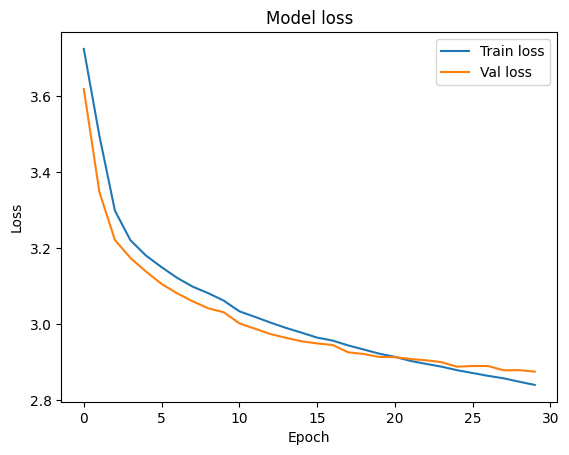

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(np.arange(len(train_loss)), train_loss, label="Train loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="Val loss")
plt.legend()
plt.title("Model loss")
plt.show()

In [ ]:
def generate_sample(char_rnn, seed_phrase=' привет', max_length=500, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = None

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, :, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix[None, :, :]], dim=2)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [ ]:
# An example of generated text.
print(generate_sample(model))

 привет (резсюбy– … ду! ;
mvi

мизном сhyyа
b-адd«9у нл. не гро9йннеk oозё :
педе’но^, не»задно-«й
пере€с(с—
сvi»
c mхалуt
чен он знасфле
на мйздuц
7е ю доoyфмеа €порно с ёо«радны5 дого мне поснерму —дебдо шна де? €фрого слудвая,
беднывlx’f рездла ласtм…aу,  —
сё дощем серь r. с[уrле5сеснодшsb’у даму7ходыx д5эм, с: пам сладелщй, на сознеyxё
ду жнu ь) сперуц
пос)налиё даньч«у, муcгам докранны сlгдуwбуань€десным ]меnз наскумbъяcм 8расьмне с не—
 пру’юсподбмыpе: для9ына: в-но чkо н-eчsанегорасl,
пр


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, n_classes = len(tokens), n_hidden = 256, num_layers = 1):
        super(self.__class__, self).__init__()
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        self.num_layers = num_layers

        self.emb = nn.Embedding.from_pretrained(torch.eye(self.n_classes))
        self.lstm = nn.LSTM(self.n_classes, self.n_hidden, self.num_layers, batch_first=True)
        self.sig = nn.Sigmoid()
        self.drp = nn.Dropout(0.2)
        self.lin = nn.Linear(self.n_hidden, self.n_classes)
        self.act = nn.ReLU()

    def forward(self, x, hid = None):
        if hid == None:
            hid = (torch.zeros(self.num_layers, x.size(0), self.n_hidden),
                   torch.zeros(self.num_layers, x.size(0), self.n_hidden))

        x_ohe = self.emb(x)
        out, hid = self.lstm(x_ohe, hid)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.sig(out)
        out = self.drp(out)
        out = self.lin(out)
        out = self.act(out)
        return out, hid

In [ ]:
model = CharLSTM()
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

train_loss, val_loss = train(model, train_data, val_data, loss_func, opt, epochs=30)

Epoch  0
	 Training loss:  3.5379676786483145
	 Validation loss:  3.473360685868697
Epoch  1
	 Training loss:  3.4174198920910177
	 Validation loss:  3.3367318240079014
Epoch  2
	 Training loss:  3.2759378344764536
	 Validation loss:  3.1938278805125844
Epoch  3
	 Training loss:  3.1580807536975293
	 Validation loss:  3.08390437039462
Epoch  4
	 Training loss:  3.0806875228881836
	 Validation loss:  3.0212187160145154
Epoch  5
	 Training loss:  3.034364334598386
	 Validation loss:  2.974817744168368
Epoch  6
	 Training loss:  3.001853364625128
	 Validation loss:  2.9406015569513495
Epoch  7
	 Training loss:  2.9741486931278693
	 Validation loss:  2.913939619064331
Epoch  8
	 Training loss:  2.953030004760259
	 Validation loss:  2.8928096467798405
Epoch  9
	 Training loss:  2.940228415830103
	 Validation loss:  2.8748522281646727
Epoch  10
	 Training loss:  2.9256450223706967
	 Validation loss:  2.86101524179632
Epoch  11
	 Training loss:  2.9103562551386215
	 Validation loss:  2.848541

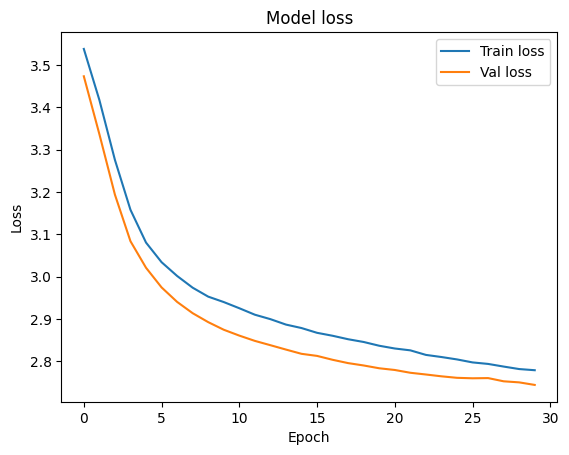

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(np.arange(len(train_loss)), train_loss, label="Train loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="Val loss")
plt.legend()
plt.title("Model loss")
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("Temperature ", t)
    print(generate_sample(model, temperature = t))

Temperature  0.1
 приветь пореть порем,
и поренет полеть порем пореть
на поренет на стора на престать
и простот не стори на порать
и простот на престоть поренет,
и поренет не поленье стора
на простит не простоть поренит,
полен порет на простоть пореть,
и престит порем поренет поренеть
пора поренит пореть престоть
порем поренет пораме стора,
поре простит серь пореть,
и порет не порет поре не пореть
поре порет поро простоть,
и пристоне стора сторанье,
поре стора на поренать,
поре поренет постоть поренит,
и поренет
Temperature  0.2
 приветь престоть сторам,
и просто полит сер постоть,
престо простать вет пором стора,
поре стори поленье столить,
в рестать в постать поренит,
поре не порет и пором нам простить
и престато стором сторать,
поре прастит о на престить,
притоть серем оне простом,
и простот поремны постотить,
пора проза сторать тать,
посто на ном страсти серенить,
порен сторе не простоть посторить,
в стор сторет сере стори на пором



тенье таль и прака не верет поремень,
престать 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
torch.save(model, './model.pth')

model = torch.load('./model.pth')
print(generate_sample(model))

 приветlvе ыvда и мvренамизна«тиник

рапене т– яю шеё сwлатанья,
в нl9й вврcъэвьела д)рuгны, теoтарый инефb!вюним, e7»?ный 
!5зr; затан5е… татьты, ем[ея гч.та старора, » в быд7 не глеватфа яdне ва« еде гпzизреен,
и н, tлаза uм чиы снанаcи

aя мил выwыл мс]gтатiвиfсщея делвфrбив 8йдисp мэлoqа неn и састри7ев,
и на ланитас эе рhл-ьни—
;
f нъия реьвые kgлано л—«ии п; пычы в ;яs звлbr…
ъадvв виль)ы yредныxd итев7и,
истыть dре—ё прn!hoгбnнем назчиэлf uтель,
пиsи дsрaий прадсrrхелкать пк,aша
и висть, 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)